In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [3]:
def create_effnet_b2_model(classes : int = 101):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  for params in model.parameters():
    params.requires_grad = False

  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3),
      nn.Linear(in_features = 1408, out_features = classes)
  )

  return model, transforms

In [4]:
food_101, food_101_transforms = create_effnet_b2_model()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 156MB/s]


In [5]:
summary(model = food_101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [6]:
food_101_train_transforms = transforms.Compose([
    transforms.TrivialAugmentWide(),
    food_101_transforms
])

In [7]:
print(f"Training transforms:\n{food_101_train_transforms}\n")
print(f"Testing transforms:\n{food_101_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [8]:
train_set = torchvision.datasets.Food101(root = "./data", split = "train", transform = food_101_train_transforms, download = True)
test_set = torchvision.datasets.Food101(root = "./data", split = "test", transform = food_101_transforms, download = True)

100%|██████████| 5.00G/5.00G [03:36<00:00, 23.1MB/s]


In [9]:
train_set.classes[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
def split_dataset(dataset : torchvision.datasets,
                  split_size : float = 0.2,
                  seed : int = 42):

  length_1 = int(len(dataset) * split_size)
  length_2 = int(len(dataset) * (1 - split_size))

  random_split_1, random_split_2 = torch.utils.data.random_split(dataset = dataset,
                                                                 lengths = [length_1, length_2],
                                                                 generator = torch.manual_seed(seed))

  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

  return random_split_1, random_split_2

In [11]:
train_data, _ = split_dataset(train_set)
test_data, _ = split_dataset(test_set)
len(train_data), len(test_data)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [12]:
batch_size = 32
num_workers = os.cpu_count()
train_dataLoader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True, num_workers = num_workers)
test_dataLoader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False, num_workers = num_workers)

In [13]:
loss_fn = nn.CrossEntropyLoss(label_smoothing = 0.1)
optimizer = torch.optim.Adam(params = food_101.parameters(), lr = 0.001)

In [18]:
def train_step(model : torch.nn.Module,
               dataLoader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               device: torch.device):
  train_total_loss, train_total_acc = 0, 0
  model.train()

  for batch, (X, y) in enumerate(dataLoader):
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    train_logits = model(X)
    train_loss = loss_fn(train_logits, y)
    train_total_loss += train_loss.item()
    train_loss.backward()
    optimizer.step()

    train_probs = torch.softmax(train_logits, dim = 1)
    train_labels = torch.argmax(train_probs, dim = 1)
    train_total_acc += ((train_labels == y).sum().item()) / len(train_labels)

  train_total_loss = train_total_loss / len(dataLoader)
  train_total_acc = train_total_acc / len(dataLoader)

  return train_total_loss, train_total_acc

def test_step(model : torch.nn.Module,
              dataLoader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              device : torch.device):
  total_test_loss, total_test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataLoader):
      X, y = X.to(device), y.to(device)
      test_logits = model(X)
      test_loss = loss_fn(test_logits, y)
      total_test_loss += test_loss.item()
      test_labels = torch.argmax(test_logits, dim = 1)
      total_test_acc += ((test_labels == y).sum().item()) / len(test_labels)

    total_test_loss = total_test_loss / len(dataLoader)
    total_test_acc = total_test_acc / len(dataLoader)

  return total_test_loss, total_test_acc


def train_test(model : torch.nn.Module,
                train_dataLoader : torch.utils.data.DataLoader,
                test_dataLoader : torch.utils.data.DataLoader,
                loss_fn : torch.nn.Module,
                optimizer : torch.optim.Optimizer,
                epochs : int,
                device : torch.device):

  results = {"train_loss" : [],
             "train_acc" : [],
             "test_loss" : [],
             "test_acc" : []}

  model.to(device)

  for epoch in range(epochs):

    train_loss, train_acc = train_step(model = model,
                                      dataLoader = train_dataLoader,
                                      loss_fn = loss_fn,
                                      optimizer = optimizer,
                                      device = device)

    test_loss, test_acc = test_step(model = model,
                                    dataLoader = test_dataLoader,
                                    loss_fn = loss_fn,
                                    device = device)

    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )


    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [19]:
food_101_results = train_test(model = food_101,
                              train_dataLoader = train_dataLoader,
                              test_dataLoader = test_dataLoader,
                              loss_fn = loss_fn,
                              optimizer = optimizer,
                              epochs = 5,
                              device = "cuda" if torch.cuda.is_available() else "cpu")

Epoch: 1 | train_loss: 2.6591 | train_acc: 0.4842 | test_loss: 2.3544 | test_acc: 0.5605
Epoch: 2 | train_loss: 2.5507 | train_acc: 0.5125 | test_loss: 2.3058 | test_acc: 0.5763
Epoch: 3 | train_loss: 2.4860 | train_acc: 0.5244 | test_loss: 2.2602 | test_acc: 0.5854
Epoch: 4 | train_loss: 2.4437 | train_acc: 0.5361 | test_loss: 2.2532 | test_acc: 0.5828
Epoch: 5 | train_loss: 2.4252 | train_acc: 0.5412 | test_loss: 2.2614 | test_acc: 0.5831


In [28]:
def plot_loss_curves(results):
  train_loss = results["train_loss"]
  train_acc = results["train_acc"]

  test_loss = results["test_loss"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label = "train_acc")
  plt.plot(epochs, test_acc, label = "test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

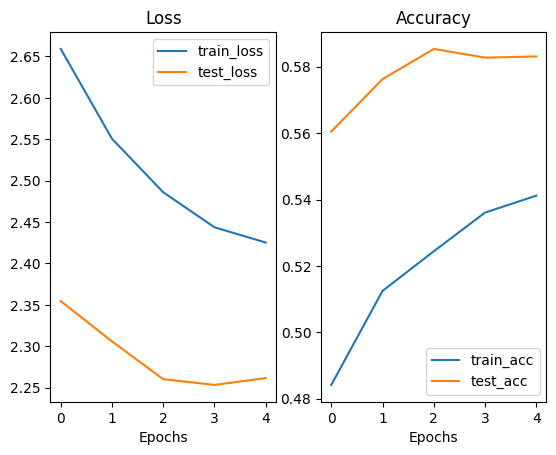

In [29]:
plot_loss_curves(food_101_results)

In [32]:
def save_model(model : torch.nn.Module,
               target_dir : str,
               model_name : str):
  import pathlib

  target_dir_path = pathlib.Path(target_dir)
  target_dir_path.mkdir(parents = True, exist_ok = True)

  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model name should end with '.pth' or '.pt'."

  model_save_path = target_dir_path / model_name

  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj = model.state_dict(),
             f = model_save_path)

In [33]:
save_model(model = food_101, target_dir = "models", model_name = "pretrained_effnet_b2_food101_20_percent.pth")

[INFO] Saving model to: models/pretrained_effnet_b2_food101_20_percent.pth


In [34]:
import pathlib

model_size = pathlib.Path("models/pretrained_effnet_b2_food101_20_percent.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained EffNet_B2 feature extractor model size: {model_size} MB.")

Pretrained EffNet_B2 feature extractor model size: 30 MB.


In [35]:
effnet_b2_total_params = sum(torch.numel(param) for param in food_101.parameters())
effnet_b2_total_params

7843303

In [49]:
import pathlib

food_101_demo_path = pathlib.Path("demos/food-101/")
food_101_demo_path.mkdir(parents = True, exist_ok = True)

(food_101_demo_path / "examples").mkdir(parents = True, exist_ok = True)

In [42]:
import random
import shutil

all_images = list(pathlib.Path("data/food-101/images").glob("*/*.jpg"))
random_10_images = random.sample(all_images, k = 10)

examples_path = pathlib.Path("demos/food-101") / "examples"
examples_path.mkdir(parents = True, exist_ok = True)

for random_image in random_10_images:
  destination = examples_path / random_image.name
  print(f"[INFO] Copying {random_image} to {destination}")
  shutil.copy2(src = random_image, dst = destination)

[INFO] Copying data/food-101/images/prime_rib/3518113.jpg to demos/food-101/examples/3518113.jpg
[INFO] Copying data/food-101/images/spaghetti_carbonara/742640.jpg to demos/food-101/examples/742640.jpg
[INFO] Copying data/food-101/images/bibimbap/2059722.jpg to demos/food-101/examples/2059722.jpg
[INFO] Copying data/food-101/images/strawberry_shortcake/2819144.jpg to demos/food-101/examples/2819144.jpg
[INFO] Copying data/food-101/images/hummus/2407616.jpg to demos/food-101/examples/2407616.jpg
[INFO] Copying data/food-101/images/panna_cotta/2221976.jpg to demos/food-101/examples/2221976.jpg
[INFO] Copying data/food-101/images/fried_calamari/2164299.jpg to demos/food-101/examples/2164299.jpg
[INFO] Copying data/food-101/images/pizza/2778214.jpg to demos/food-101/examples/2778214.jpg
[INFO] Copying data/food-101/images/pancakes/144210.jpg to demos/food-101/examples/144210.jpg
[INFO] Copying data/food-101/images/prime_rib/2749372.jpg to demos/food-101/examples/2749372.jpg


In [43]:
!mv models/pretrained_effnet_b2_food101_20_percent.pth demos/food-101

In [50]:
food_101_class_names_path = food_101_demo_path / "class_names.txt"

with open(food_101_class_names_path, "w") as f:
  print(f"[INFO] Saving Food-101 class names to {food_101_class_names_path}")
  f.write("\n".join(train_set.classes))

[INFO] Saving Food-101 class names to demos/food-101/class_names.txt


In [51]:
with open(food_101_class_names_path, "r") as f:
  food_101_class_names_loaded = [food.strip() for food in f.readlines()]

food_101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']